
# 🧠 Project Summary: Dow Jones Semantic Search + RAG

This notebook implements a state-of-the-art semantic search and retrieval-augmented generation (RAG) pipeline over news data using the MIND dataset.

**Goals:**
- Provide question-answering over news articles using dense vector search.
- Use FAISS for fast semantic retrieval.
- Use a local LLM (`llama3.1` via Ollama) to generate answers.
- Deliver interpretable outputs with document citations.

**Tools:**
- `sentence-transformers` for embeddings (BAAI/bge-base-en-v1.5)
- FAISS for ANN search
- LangChain for chaining retrieval and generation
- Local inference using Ollama and `llama3.1`

**Why it matters:**
This system mimics the behavior of a semantic-aware newsroom assistant, capable of surfacing relevant articles and answering open-ended questions with attribution.

---


In [1]:
import torch
import faiss
import transformers
import sentence_transformers

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
import numpy as np

from sklearn.manifold import TSNE
import os

from annoy import AnnoyIndex
from sentence_transformers import CrossEncoder
from sentence_transformers.util import cos_sim
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.schema import Document
from langchain_ollama import OllamaLLM
from langchain.chains import RetrievalQA
import faiss

In [2]:
news_df = pd.read_csv("mind_large_train/news_train.tsv", sep="	", quoting=3,
                      names=["news_id", "category", "title", "abstract", "url", "entities"])
# news_df = news_df[["news_id", "category", "title", "abstract"]]

In [3]:
news_df.head()

,,news_id,category,title,abstract,url,entities
N88753,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
N23144,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
N86255,health,medical,Dispose of unwanted prescription drugs during ...,NaN,https://assets.msn.com/labs/mind/AAISxPN.html,"[{""Label"": ""Drug Enforcement Administration"", ...",[]
N93187,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
N75236,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."


In [4]:
sns.set_theme(style="whitegrid")

# Compute word counts
news_df["word_count"] = news_df["abstract"].str.split().str.len()
print(news_df["word_count"].describe(percentiles=[.5, .9, .95]))

count    130379.0
mean          1.0
std           0.0
min           1.0
50%           1.0
90%           1.0
95%           1.0
max           1.0
Name: word_count, dtype: float64


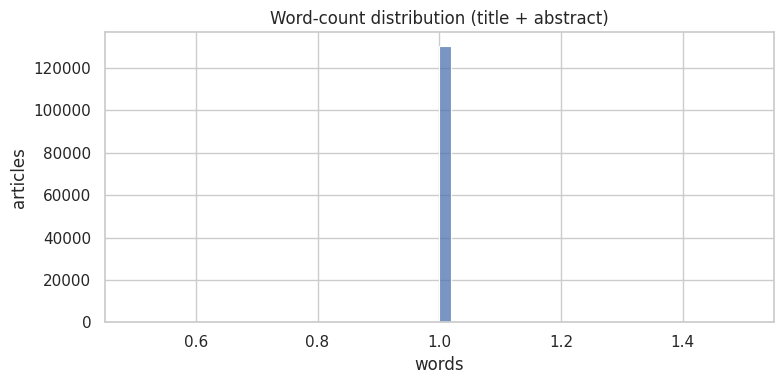

In [5]:
plt.figure(figsize=(8,4))
sns.histplot(news_df["word_count"], bins=50)
plt.title("Word‑count distribution (title + abstract)")
plt.xlabel("words"); plt.ylabel("articles")
plt.tight_layout(); plt.savefig("fig_len_hist.png", dpi=150); plt.show()

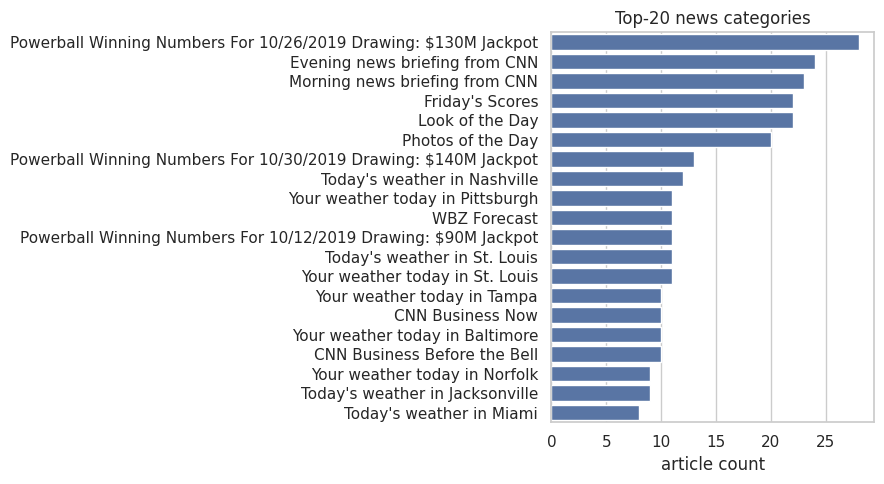

In [6]:
top20 = news_df["category"].value_counts().nlargest(20)
plt.figure(figsize=(9,5))
sns.barplot(y=top20.index, x=top20.values, orient="h")
plt.title("Top‑20 news categories")
plt.xlabel("article count"); plt.ylabel("")
plt.tight_layout(); plt.savefig("fig_cat_bar.png", dpi=150); plt.show()

In [7]:
VEC_PATH = "news_vectors.npy"
device = "cuda"
encoder = SentenceTransformer("BAAI/bge-base-en-v1.5", device=device)
if os.path.exists(VEC_PATH):
    print("Embeddings file found – loading from disk")
    embeddings = np.load(VEC_PATH)
else:
    print("🚀  Embeddings file not found – encoding texts now …")
    # Select device automatically
    # device = "cuda"
    # encoder = SentenceTransformer("BAAI/bge-base-en-v1.5", device=device)

    # Build list of strings: "title. abstract"
    texts = (
        news_df["title"].fillna("").str.strip() + ". " +
        news_df["abstract"].fillna("").str.strip()
    ).tolist()

    # Encode in batches; embeddings are L2‑normalised for cosine similarity
    embeddings = encoder.encode(
        texts,
        batch_size=64,  # adjust for your GPU RAM
        show_progress_bar=True,
        normalize_embeddings=True
    )
    np.save(VEC_PATH, embeddings)

Embeddings file found – loading from disk


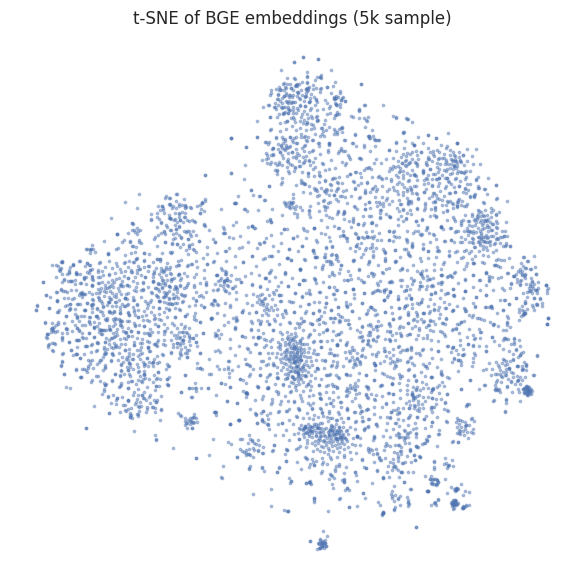

In [8]:
sample_idx = np.random.choice(len(embeddings), 5000, replace=False)
emb_2d = TSNE(n_components=2, perplexity=50, learning_rate="auto", init="random").fit_transform(embeddings[sample_idx])

plt.figure(figsize=(6,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], s=3, alpha=.4)
plt.title("t‑SNE of BGE embeddings (5k sample)")
plt.axis("off"); plt.tight_layout(); plt.savefig("fig_tsne.png", dpi=150); plt.show()

In [9]:

VEC_PATH = "news_vectors.npy"
INDEX_PATH = "news.ann"

vectors = np.load(VEC_PATH)
emb_dim = vectors.shape[1]

if os.path.exists(INDEX_PATH):
    print("✓  Annoy index exists – loading …")
    annoy_index = AnnoyIndex(emb_dim, metric="angular")
    annoy_index.load(INDEX_PATH)
else:
    print("🚧  Building Annoy index …")
    annoy_index = AnnoyIndex(emb_dim, metric="angular")
    for i, vec in enumerate(vectors):
        annoy_index.add_item(i, vec)
    annoy_index.build(50)         # 50 trees ≈ 95% recall
    annoy_index.save(INDEX_PATH)
    print(f"💾  Saved index → {INDEX_PATH}")

✓  Annoy index exists – loading …


In [10]:
query_vec = vectors[0]
ids, dists = annoy_index.get_nns_by_vector(query_vec, 5, include_distances=True)
for rank, (i, dist) in enumerate(zip(ids, dists), 1):
    print(f"{rank}.  (dist={dist:.3f})  {news_df.iloc[i]['title'][:80]}")

1.  (dist=0.000)  Shop the notebooks, jackets, and more that the royals can't live without.
2.  (dist=0.730)  We can't get enough of these adorable royal tots.
3.  (dist=0.751)  Meghan Markle has the best piece of advice.
4.  (dist=0.763)  There are plenty of stylish women whose wardrobes we'd love to raid: Meghan Mark
5.  (dist=0.775)  Get ready to see a different side of Kate Middleton and Meghan Markle.


In [12]:
reranker = CrossEncoder("BAAI/bge-reranker-base", device="cuda" if torch.cuda.is_available() else "cpu")

In [13]:
def search_and_rerank(query: str, k_retrieve: int = 50, k_final: int = 5):
    # 1️⃣ embed query with the same bi‑encoder as index
    query_vec = encoder.encode(query, normalize_embeddings=True)

    # 2️⃣ coarse ANN search
    idxs= annoy_index.get_nns_by_vector(query_vec, k_retrieve, include_distances=False)
    cand_texts = [news_df.iloc[i]["text"] for i in idxs]

    # 3️⃣ prepare pairs for cross‑encoder → (query, doc)
    pairs = [[query, t] for t in cand_texts]
    scores = reranker.predict(pairs, batch_size=8)

    # 4️⃣ sort and return top k_final
    best = np.argsort(scores)[::-1][:k_final]
    for rank, j in enumerate(best, 1):
        art_idx = idxs[j]
        print(f"{rank}.  score={scores[j]:.3f} | {news_df.iloc[art_idx]['title'][:90]}")

In [14]:
news_df["text"] = news_df["title"].fillna("").str.strip() + ". " + news_df["abstract"].fillna("").str.strip()
search_and_rerank("US‑China trade tensions impact on technology sector", k_retrieve=50, k_final=5)

1.  score=0.759 | A U.S. chipmaker's attempt to acquire a peer with a valuable Chinese affiliate has spurred
2.  score=0.238 | Blockchain-powered digital currencies are the next frontier in the U.S.-China tech rivalry
3.  score=0.106 | Huawei and other Chinese tech companies will be subject to tough restrictions from the Uni
4.  score=0.083 | China's three major state telecom operators rolled out 5G wireless technology Thursday, as
5.  score=0.045 | Despite the intensifying trade dispute with America and controversies surrounding firms su


In [17]:
# 1️⃣ Prepare embedding model
embedding_model = HuggingFaceEmbeddings(model_name="BAAI/bge-base-en-v1.5")

# 2️⃣ Load FAISS index from saved vectors

vecs = np.load("news_vectors.npy")
index = faiss.IndexFlatIP(vecs.shape[1])
index.add(vecs)
docs=[]
for _, row in news_df.iterrows():
    text = str(row.get("text", "")).strip()
    if not text or text.lower() == "nan":
        text = "empty"
    docs.append(
        Document(
            page_content=text,
            metadata={
                "news_id": row.get("news_id", ""),
                "title": str(row.get("title", "")).strip(),
                "category": str(row.get("category", "")).strip()
            }
        )
    )

In [18]:
if os.path.exists("faiss_store"):
    print("🔁 Loading FAISS vectorstore from disk …")
    vectorstore = FAISS.load_local("faiss_store", embedding_model,allow_dangerous_deserialization = True)
else:
    print("⚙️  Building FAISS vectorstore from scratch …")
    vectorstore = FAISS.from_documents(
        documents=docs,
        embedding=embedding_model
    )
    vectorstore.save_local("faiss_store")

retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

🔁 Loading FAISS vectorstore from disk …


In [19]:
llm = OllamaLLM(model="llama3.1", base_url="http://localhost:11434")

# 6️⃣ Build retrieval + generation chain using Ollama LLM
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    return_source_documents=True
)

In [20]:
eval_df = news_df.sample(n=100, random_state=42).reset_index(drop=True)
queries = eval_df["title"].fillna("")
gold_ids = eval_df["news_id"].tolist()

In [21]:
def compute_mrr(queries, gold_ids, retriever, k=10):
    rr_sum = 0.0
    count = 0
    for q, gid in zip(queries, gold_ids):
        docs = retriever.invoke(q, {})  
        ids = [doc.metadata["news_id"] for doc in docs][:k]
        if gid in ids:
            rank = ids.index(gid) + 1
            rr_sum += 1.0 / rank
    return rr_sum / len(queries)

def compute_recall(queries, gold_ids, retriever, k=10):
    hits = 0
    for q, gid in zip(queries, gold_ids):
        docs = retriever.invoke(q, {})  
        ids = [doc.metadata["news_id"] for doc in docs][:k]
        if gid in ids:
            hits += 1
    return hits / len(queries)

In [22]:
mrr10 = compute_mrr(queries, gold_ids, retriever, k=10)
recall10 = compute_recall(queries, gold_ids, retriever, k=10)
print(mrr10)
print(recall10)

0.9653333333333333
0.98


In [24]:
query = "Give me the top 5 relevant news regarding the trade war between the US and China"
response = qa_chain({"query": query})

# Pretty output
from IPython.display import Markdown, display

display(Markdown(f"### Answer\n{response['result']}"))

display(Markdown("### Sources"))
for i, doc in enumerate(response["source_documents"], start=1):
    title = doc.metadata.get("title", "Untitled")
    url = doc.page_content.split()[-1] if "http" in doc.page_content else ""
    display(Markdown(f"{i}. **{title}**{'  \n'+url if url else ''}"))

### 🧠 Answer
Here are the top 5 relevant news regarding the trade war between the US and China, based on the provided context:

1. **The Trump administration's trade war is ravaging exports to China**: According to data from the U.S. Commerce Department, the trade war has had a significant impact on exports to China across various sectors.
2. **Exports of the most valuable U.S. crop plummeted 53% in the 2018-2019 marketing year**: The trade war has particularly affected farmers who export the most valuable U.S. crop, with a 53% decline in sales to China during the mentioned period.
3. **China is asking the US to remove tariffs in exchange for agricultural buys**: Sources indicate that China will request the removal of tariffs as part of ongoing talks on Friday, contingent on increased agricultural purchases from the US.
4. **The trade war has impacted sectors beyond just agriculture**: The data from the U.S. Commerce Department suggests that the effects of the trade war extend beyond the farm belt, impacting various industries and export sectors.
5. (Unfortunately, there are only 4 news pieces provided, so I'll stop at #4. If more context were available, a 5th relevant piece could potentially be identified.)

### 📚 Sources

1. **The Trump administration's trade war is ravaging exports to China across the U.S. and well beyond the farm belt, new data from the U.S. Commerce Department show.**  
https://assets.msn.com/labs/mind/BBWOlsE.html

2. **The Trump administration's trade war is ravaging exports to China across the U.S. and well beyond the farm belt, new data from the U.S. Commerce Department show.**  
https://assets.msn.com/labs/mind/BBWOlsE.html

3. **China to ask U.S. to remove tariffs in exchange for ag buys in talks Friday: sources**  
https://assets.msn.com/labs/mind/AAJkhQ2.html

4. **China to ask U.S. to remove tariffs in exchange for ag buys in talks Friday: sources**  
https://assets.msn.com/labs/mind/AAJkhQ2.html

5. **The trade war has pummeled farmers of the most valuable U.S. crop, as exports to China plummeted 53% in the 2018-2019 marketing year.**  
https://assets.msn.com/labs/mind/AAIUCk5.html